In [1]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

ImportError: cannot import name 'BertModelLayer' from 'bert' (C:\Users\Admin\BE PROJECT\fakenews\bert\__init__.py)

In [ ]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [ ]:
train = train.append(valid).reset_index(drop=True)

In [ ]:
train.shape

(13784, 2)

In [ ]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


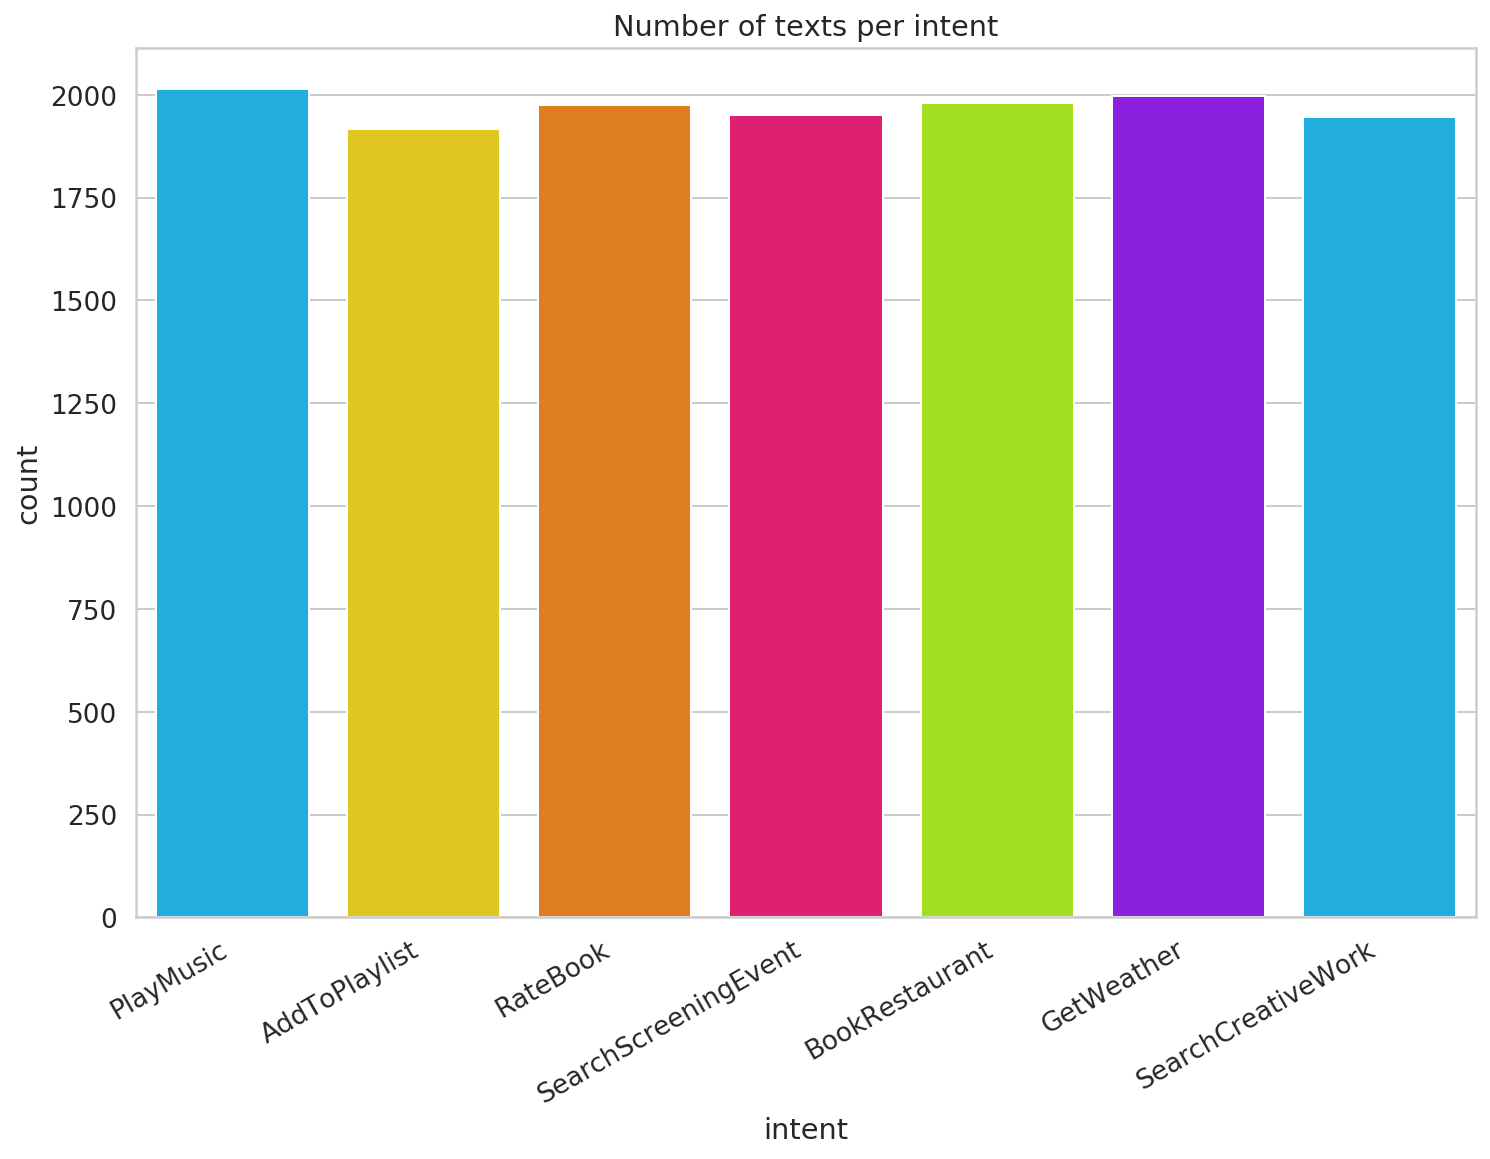

In [ ]:
chart = sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right')

# Intent Recognition with BERT

In [1]:
bert_model_name="wwm_uncased_L-24_H-1024_A-16"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

NameError: name 'os' is not defined

## Preprocessing

In [ ]:
class FakeNews:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes=[0, 1], max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[FakeNews.DATA_COLUMN], row[FakeNews.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [ ]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [ ]:
tokenizer.tokenize("I can't wait to visit Bulgaria again!")

['i', 'can', "'", 't', 'wait', 'to', 'visit', 'bulgaria', 'again', '!']

In [1]:
tokenizer.tokenize("I 44 7865 to visit Bulgaria again!")

NameError: name 'tokenizer' is not defined

In [ ]:
tokens = tokenizer.tokenize("I can't wait to visit Bulgaria again!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8063, 2153, 999]

This is Where you make the Model Architecture

In [ ]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

## Training

In [ ]:
classes = train.intent.unique().tolist().sort()

data = FakeNews(train, test, tokenizer, classes, max_seq_len=128)

13784it [00:05, 2662.74it/s]
700it [00:00, 2711.22it/s]


max seq_len 38


In [ ]:
data.train_x.shape

(13784, 38)

In [ ]:
data.train_x[0]

array([ 101, 2377, 3769,  102,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])

In [ ]:
data.train_y[0]

0

In [ ]:
data.max_seq_len

38

In [ ]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 38, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5336bd65f8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 38)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 38, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5383  

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Train on 12405 samples, validate on 1379 samples
Epoch 1/5
12405/12405 [==============================] - 306s 25ms/sample - loss: 1.3032 - acc: 0.8772 - val_loss: 1.1730 - val_acc: 0.9927
Epoch 2/5
12405/12405 [==============================] - 277s 22ms/sample - loss: 1.1844 - acc: 0.9823 - val_loss: 1.1701 - val_acc: 0.9949
Epoch 3/5
12405/12405 [==============================] - 276s 22ms/sample - loss: 1.1784 - acc: 0.9877 - val_loss: 1.1712 - val_acc: 0.9942
Epoch 4/5
12405/12405 [==============================] - 276s 22ms/sample - loss: 1.1776 - acc: 0.9883 - val_loss: 1.1691 - val_acc: 0.9964
Epoch 5/5
12405/12405 [==============================] - 275s 22ms/sample - loss: 1.1771 - acc: 0.9884 - val_loss: 1.1713 - val_acc: 0.9935


## Evaluation

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir log

This cell output is too large and can only be displayed while logged in.


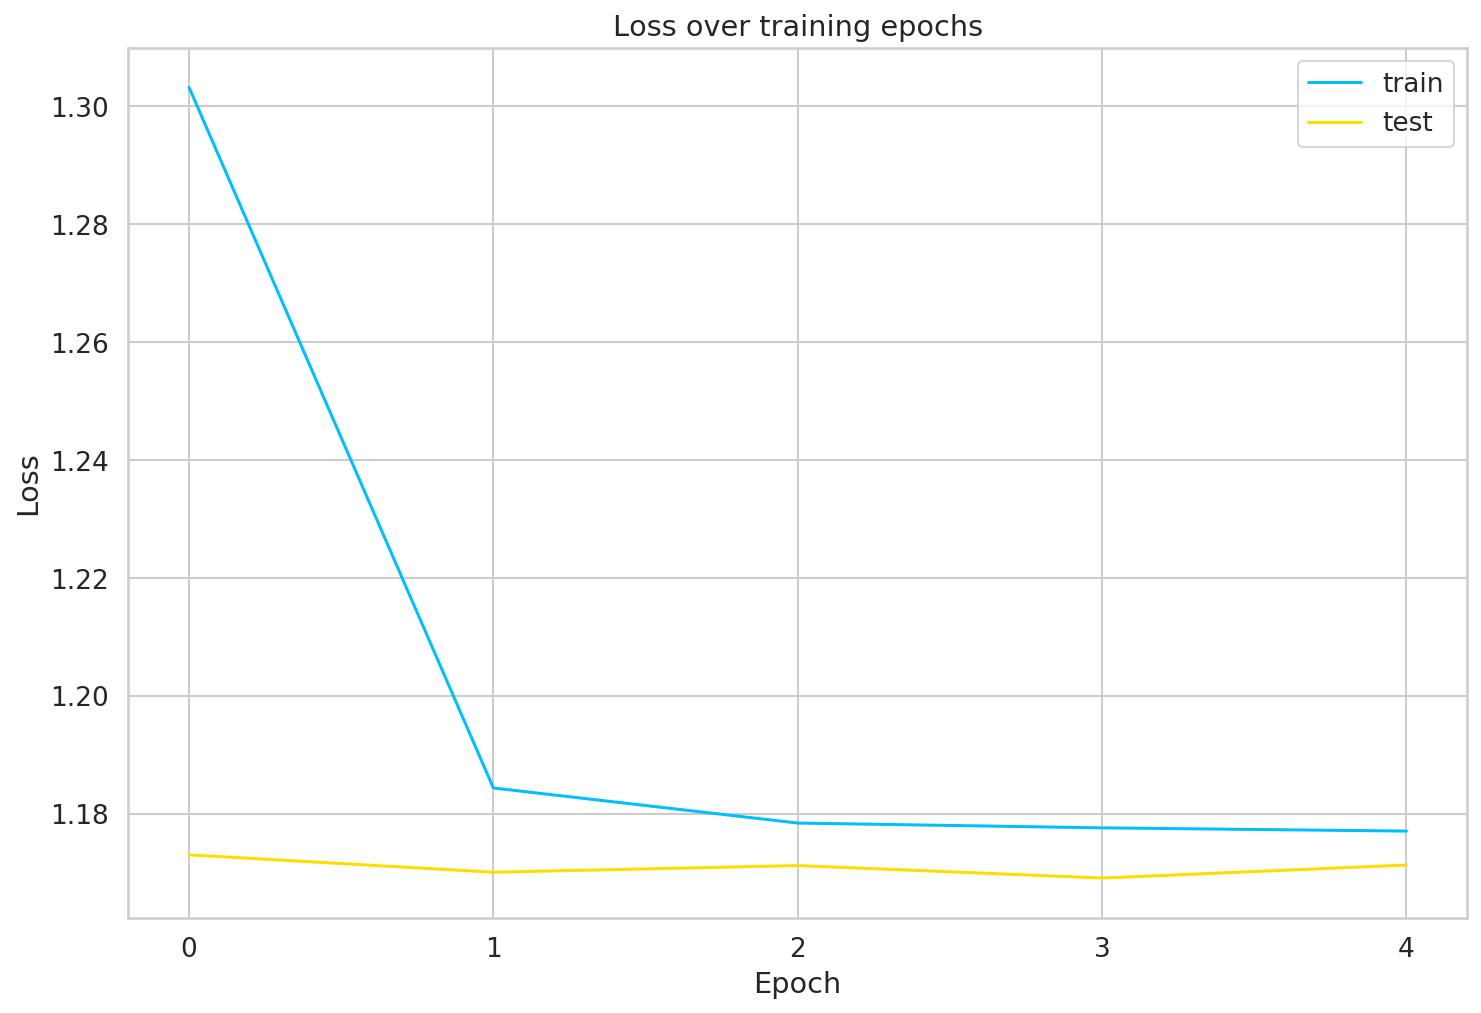

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

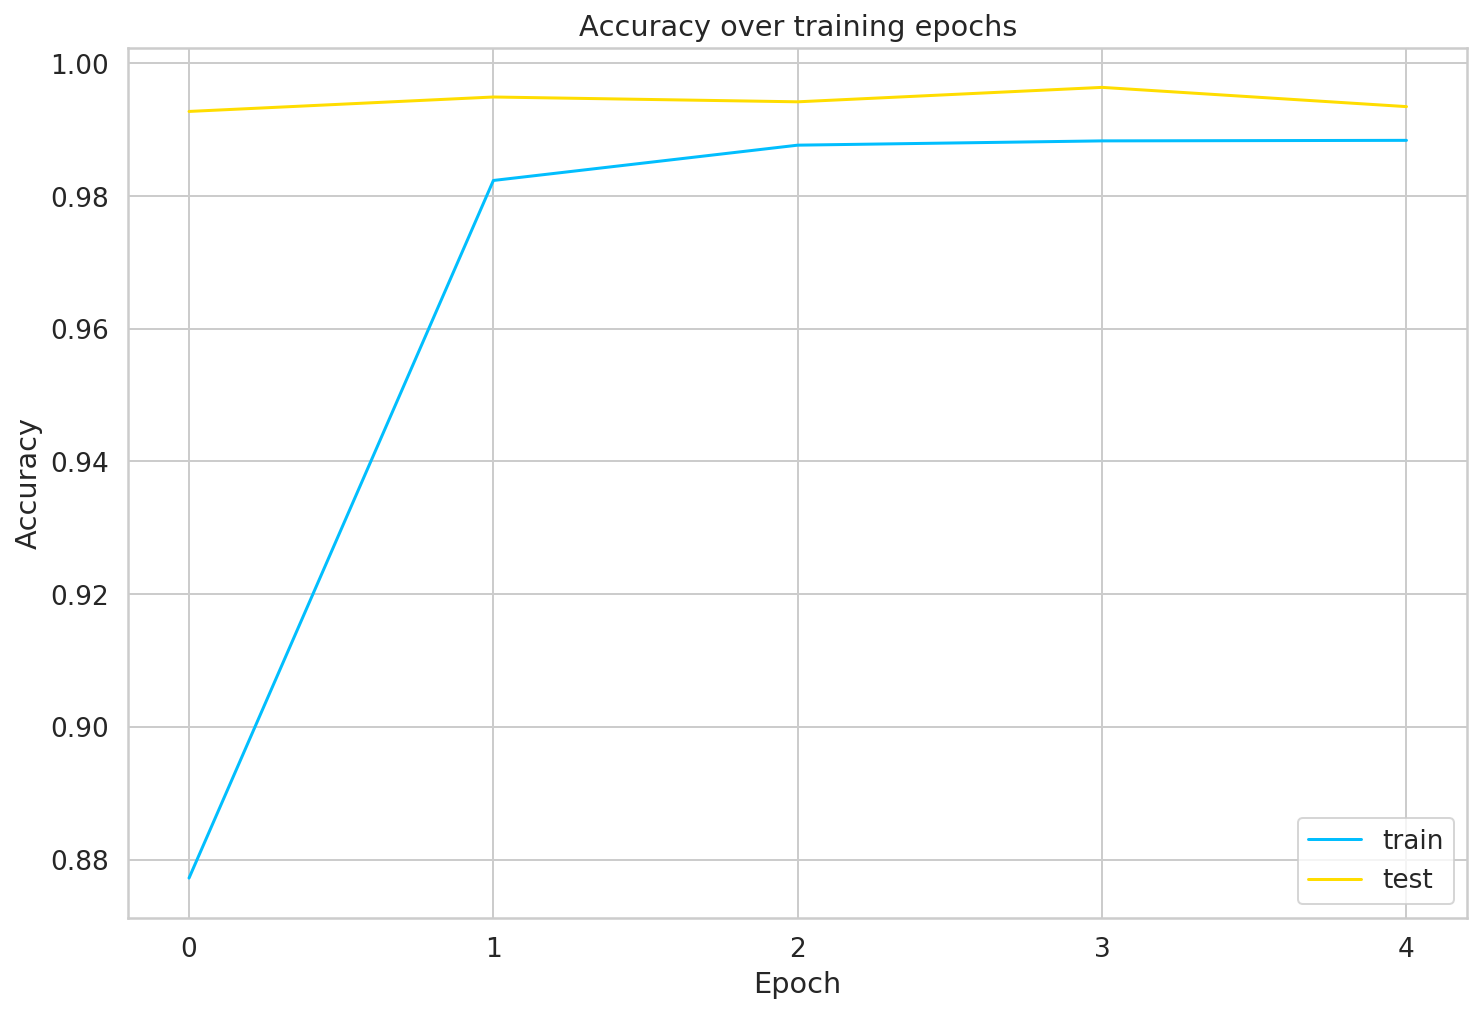

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [ ]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

700/700 [==============================] - 2s 3ms/sample - loss: 1.1892 - acc: 0.9771
train acc 0.9915119
test acc 0.9771429


In [ ]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [ ]:
print(classification_report(data.test_y, y_pred, target_names=classes))

                      precision    recall  f1-score   support

           PlayMusic       0.95      1.00      0.97        86
       AddToPlaylist       1.00      0.99      1.00       124
            RateBook       1.00      1.00      1.00        80
SearchScreeningEvent       0.98      0.93      0.96       107
      BookRestaurant       0.98      1.00      0.99        92
          GetWeather       1.00      0.98      0.99       104
  SearchCreativeWork       0.94      0.94      0.94       107

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



In [ ]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

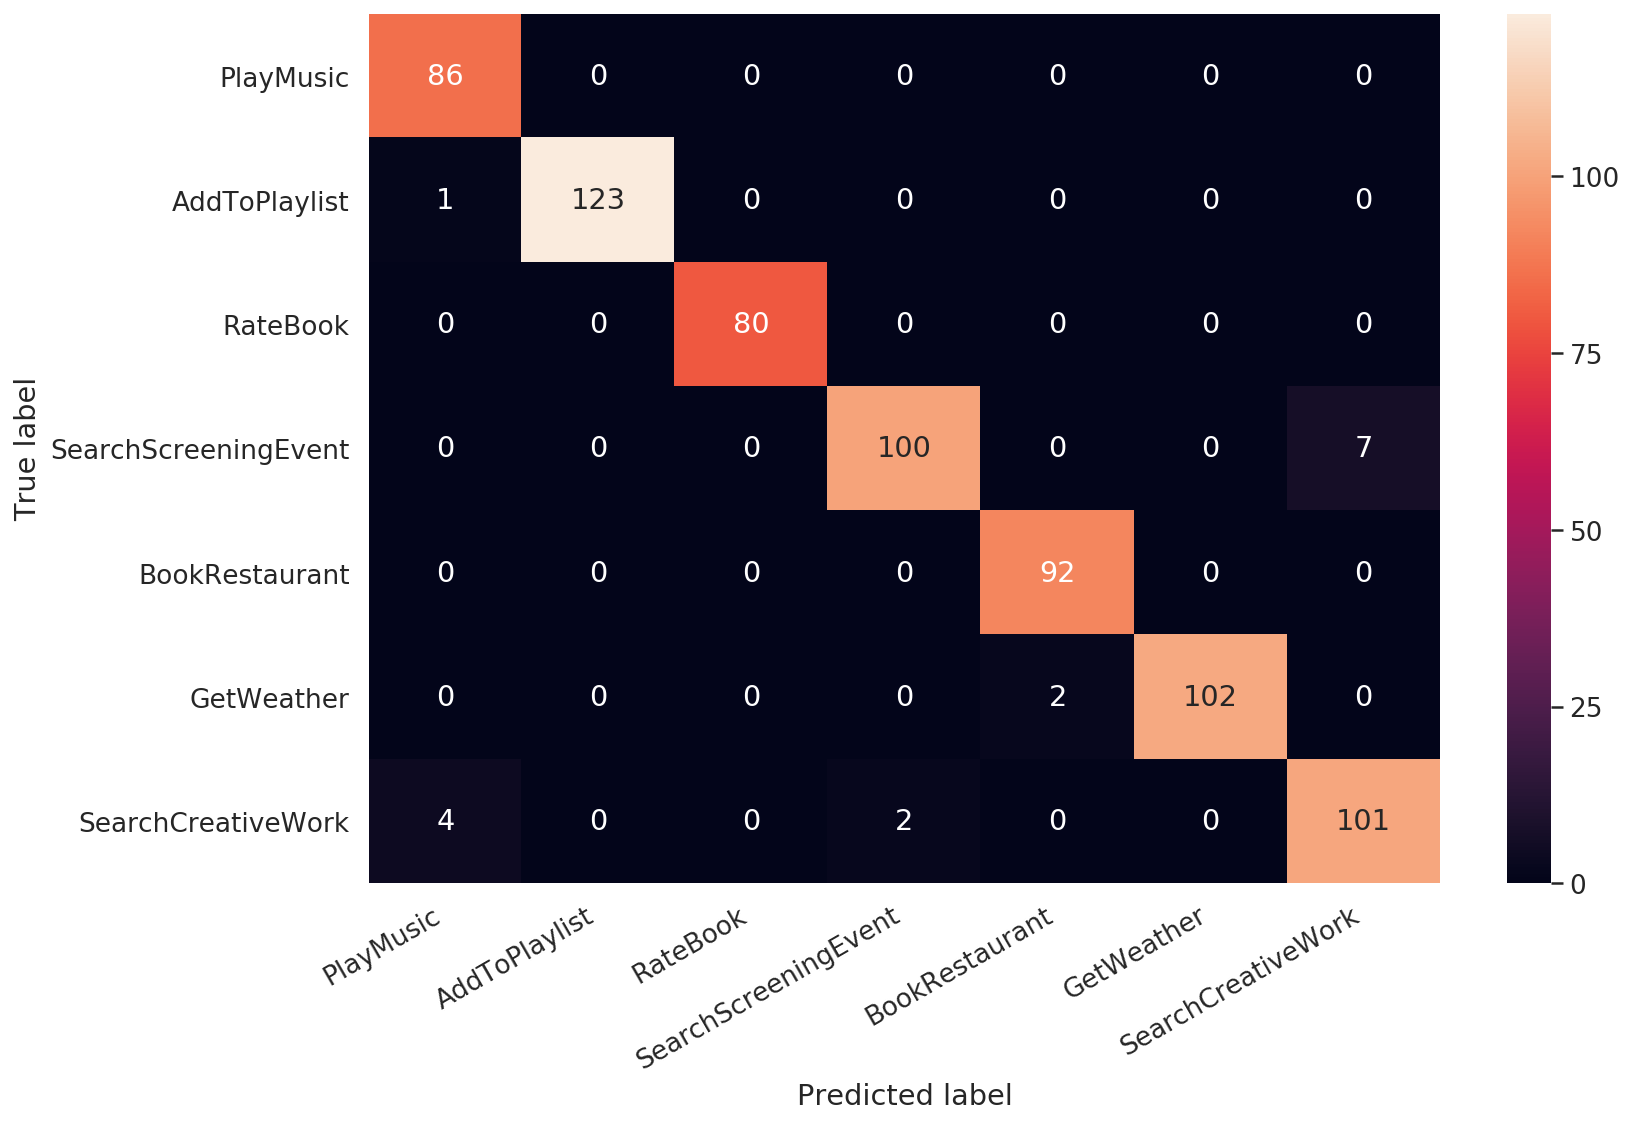

In [ ]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
def pre(sentences: List):
    pred_tokens = map(tokenizer.tokenize, sentences)
    pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
    pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

    pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
    pred_token_ids = np.array(list(pred_token_ids))
    return(pred_token_ids)

In [ ]:
sentences = [
  "Play our song now",
  "Rate this book as awful"
]

pred_token_ids = pre(sentences)

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: Play our song now 
intent: PlayMusic

text: Rate this book as awful 
intent: RateBook

